# MIS 583 Assignment 5: YOLO Object Detection on PASCAL VOC

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 賴壹誠, M124020042.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## How to Get Data

請先到共用雲端硬碟將檔案 `VOCdevkit_2007.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1jWpMbjxFl1JALOcwRMg3dl44UAURQ2XB/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `VOCdevkit_2007.zip`

+ `VOC2007` : 包含了train/val的所有圖片
+ `VOC2007test` : 包含了test的所有圖片

其中`train`的圖片 3756 張，`val`的圖片 1255 張，`test` 的圖片 4950 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [2]:
!unzip -qq ./drive/MyDrive/VOCdevkit_2007.zip

# Import package

In [3]:
import os
import random

import cv2
import numpy as np

import csv

import torch
from torch.utils.data import DataLoader
from torchvision import models

import sys
sys.path.append('/content/drive/MyDrive/Colab/HW5/A5')

from src.resnet_yolo import resnet50 ,resnet101, resnet152
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate, test_evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import write_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [22]:
load_network_path = None #'checkpoints/best_detector.pth'
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

**Notice: Please put "VOCdevkit_2007" folder under data folder.**

In [25]:
file_root_train = '/content/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = '/content/drive/MyDrive/Colab/HW5/A5/data/voc2007train.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 3756 train images


In [26]:
file_root_val = '/content/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_val = '/content/drive/MyDrive/Colab/HW5/A5/data/voc2007val.txt'

val_dataset = VocDetectorDataset(root_img_dir=file_root_val,dataset_file=annotation_file_val,train=False, S=S)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d val images' % len(val_dataset))

Initializing dataset
Loaded 1255 val images


In [27]:
data = train_dataset[0]

## Set up training tools

In [28]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [29]:
best_val_loss = np.inf
learning_rate = 1e-3
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the val data
    if (epoch + 1) % 5 == 0:
        val_aps = evaluate(net, val_dataset_file=annotation_file_val, img_root=file_root_val)
        print(epoch, val_aps)
    with torch.no_grad():
        val_loss = 0.0
        net.eval()
        for i, data in enumerate(val_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            val_loss += loss_dict['total_loss'].item()
        val_loss /= len(val_loader)

    if best_val_loss > val_loss:
        best_val_loss = val_loss
        print('Updating best val loss: %.5f' % best_val_loss)
        torch.save(net.state_dict(),'/content/drive/MyDrive/Colab/HW5/A5/checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'/content/drive/MyDrive/Colab/HW5/A5/checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'/content/drive/MyDrive/Colab/HW5/A5/checkpoints/detector.pth')





Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/157], Loss: total=24.094, reg=0.818, containing_obj=0.349, no_obj=16.220, cls=6.706
Epoch [1/50], Iter [100/157], Loss: total=14.270, reg=0.624, containing_obj=0.452, no_obj=8.231, cls=4.963
Epoch [1/50], Iter [150/157], Loss: total=10.673, reg=0.518, containing_obj=0.512, no_obj=5.550, cls=4.094
Updating best val loss: 3.32048


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/157], Loss: total=3.047, reg=0.259, containing_obj=0.682, no_obj=0.152, cls=1.954
Epoch [2/50], Iter [100/157], Loss: total=2.971, reg=0.250, containing_obj=0.711, no_obj=0.142, cls=1.869
Epoch [2/50], Iter [150/157], Loss: total=2.916, reg=0.237, containing_obj=0.730, no_obj=0.133, cls=1.817
Updating best val loss: 2.54404


Starting epoch 3 / 50
Learning Rate for this epoch: 0.001
Epoch [3/50], Iter [50/157], Loss: total=2.475, reg=0.204, containing_obj=0.746, no_obj=0.102, cls=1.422
Epoch [3/50],

100%|██████████| 1255/1255 [00:30<00:00, 41.06it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this cl

Updating best val loss: 1.93535


Starting epoch 6 / 50
Learning Rate for this epoch: 0.001
Epoch [6/50], Iter [50/157], Loss: total=1.759, reg=0.146, containing_obj=0.834, no_obj=0.056, cls=0.723
Epoch [6/50], Iter [100/157], Loss: total=1.789, reg=0.146, containing_obj=0.856, no_obj=0.055, cls=0.732
Epoch [6/50], Iter [150/157], Loss: total=1.800, reg=0.146, containing_obj=0.860, no_obj=0.054, cls=0.740
Updating best val loss: 1.88324


Starting epoch 7 / 50
Learning Rate for this epoch: 0.001
Epoch [7/50], Iter [50/157], Loss: total=1.718, reg=0.139, containing_obj=0.884, no_obj=0.050, cls=0.645
Epoch [7/50], Iter [100/157], Loss: total=1.693, reg=0.137, containing_obj=0.871, no_obj=0.049, cls=0.637
Epoch [7/50], Iter [150/157], Loss: total=1.694, reg=0.137, containing_obj=0.877, no_obj=0.048, cls=0.632
Updating best val loss: 1.81688


Starting epoch 8 / 50
Learning Rate for this epoch: 0.001
Epoch [8/50], Iter [50/157], Loss: total=1.609, reg=0.128, containing_obj=0.873, no_obj=0.

100%|██████████| 1255/1255 [00:30<00:00, 41.46it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this cl

Updating best val loss: 1.72674


Starting epoch 11 / 50
Learning Rate for this epoch: 0.001
Epoch [11/50], Iter [50/157], Loss: total=1.505, reg=0.114, containing_obj=0.920, no_obj=0.038, cls=0.433
Epoch [11/50], Iter [100/157], Loss: total=1.494, reg=0.115, containing_obj=0.913, no_obj=0.038, cls=0.428
Epoch [11/50], Iter [150/157], Loss: total=1.495, reg=0.115, containing_obj=0.916, no_obj=0.038, cls=0.426
Updating best val loss: 1.68333


Starting epoch 12 / 50
Learning Rate for this epoch: 0.001
Epoch [12/50], Iter [50/157], Loss: total=1.445, reg=0.103, containing_obj=0.933, no_obj=0.037, cls=0.372
Epoch [12/50], Iter [100/157], Loss: total=1.421, reg=0.104, containing_obj=0.914, no_obj=0.037, cls=0.366
Epoch [12/50], Iter [150/157], Loss: total=1.447, reg=0.106, containing_obj=0.927, no_obj=0.037, cls=0.376


Starting epoch 13 / 50
Learning Rate for this epoch: 0.001
Epoch [13/50], Iter [50/157], Loss: total=1.414, reg=0.105, containing_obj=0.921, no_obj=0.037, cls=0.350
Epoch [

100%|██████████| 1255/1255 [00:31<00:00, 39.24it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.03377504848093084---
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0---
---class bottle ap 0.02488824296842024---
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0014684287812041117---
---class pottedplant ap 0.006578947368421052---
---class sheep ap 0.0---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0--- (no predictions for this class)
---map 0.0033355333799488123---
14

Updating best val loss: 1.67420


Starting epoch 16 / 50
Learning Rate for this epoch: 0.001
Epoch [16/50], Iter [50/157], Loss: total=1.351, reg=0.089, containing_obj=0.929, no_obj=0.040, cls=0.292
Epoch [16/50], Iter [100/157], Loss: total=1.362, reg=0.094, containing_obj=0.938, no_obj=0.041, cls=0.289
Epoch [16/50], Iter [150/157], Loss: total=1.376, reg=0.096, containing_obj=0.945, no_obj=0.041, cls=0.293
Updating best val loss: 1.65763


Starting epoch 17 / 50
Learning Rate for this epoch: 0.001
Epoch [17/50], Iter [50/157], Loss: total=1.305, reg=0.092, containing_obj=0.903, no_obj=0.044, cls=0.266
Epoch [17/50], Iter [100/157], Loss: total=1.327, reg=0.093, containing_obj=0.924, no_obj=0.044, cls=0.266
Epoch [17/50], Iter [150/157], Loss: total=1.349, reg=0.094, containing_obj=0.939, no_obj=0.044, cls=0.272


Starting epoch 18 / 50
Learning Rate for this epoch: 0.001
Epoch [18/50], Iter [50/157], Loss: total=1.326, reg=0.093, containing_obj=0.916, no_obj=0.048, cls=0.270
Epoch [

100%|██████████| 1255/1255 [00:32<00:00, 39.17it/s]


---class aeroplane ap 0.006666666666666667---
---class bicycle ap 0.07462252033680605---
---class bird ap 0.0350564468211527---
---class boat ap 0.03909465020576131---
---class bottle ap 0.004726992089523442---
---class bus ap 0.11257575757575757---
---class car ap 0.1126210748123315---
---class cat ap 0.015053763440860218---
---class chair ap 0.04333487102259922---
---class cow ap 0.007246376811594203---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.021381306865177835---
---class horse ap 0.3639447455848924---
---class motorbike ap 0.05434782608695651---
---class person ap 0.05488716771398482---
---class pottedplant ap 0.008682420336555674---
---class sheep ap 0.01449983708048224---
---class sofa ap 0.025---
---class train ap 0.06081081081081082---
---class tvmonitor ap 0.15171303780595025---
---map 0.06031331360339316---
19 [0.006666666666666667, 0.07462252033680605, 0.0350564468211527, 0.03909465020576131, 0.004726992089523442, 0.11257575757575757,

100%|██████████| 1255/1255 [00:32<00:00, 38.44it/s]


---class aeroplane ap 0.08375496031746031---
---class bicycle ap 0.17759302961273404---
---class bird ap 0.14421919618415238---
---class boat ap 0.07987280209502431---
---class bottle ap 0.01821249582358837---
---class bus ap 0.1810516934046346---
---class car ap 0.23380988531183686---
---class cat ap 0.01774193548387097---
---class chair ap 0.10204622017704709---
---class cow ap 0.14447625588077423---
---class diningtable ap 0.031746031746031744---
---class dog ap 0.0907258064516129---
---class horse ap 0.35876482856977976---
---class motorbike ap 0.09602362684204116---
---class person ap 0.13649661848460945---
---class pottedplant ap 0.042444121883975075---
---class sheep ap 0.07467572985399809---
---class sofa ap 0.08333333333333333---
---class train ap 0.1940911499735029---
---class tvmonitor ap 0.2634495280956251---
---map 0.12772646247628164---
24 [0.08375496031746031, 0.17759302961273404, 0.14421919618415238, 0.07987280209502431, 0.01821249582358837, 0.1810516934046346, 0.233809

100%|██████████| 1255/1255 [00:32<00:00, 38.05it/s]


---class aeroplane ap 0.11939776046531236---
---class bicycle ap 0.2585955360837051---
---class bird ap 0.2668420567195451---
---class boat ap 0.05871828788495455---
---class bottle ap 0.05564339325288235---
---class bus ap 0.2528406143960666---
---class car ap 0.33033291571602097---
---class cat ap 0.08371735791090629---
---class chair ap 0.11560341470988897---
---class cow ap 0.21995245763361707---
---class diningtable ap 0.015873015873015872---
---class dog ap 0.16292049645513298---
---class horse ap 0.42581089351285195---
---class motorbike ap 0.14369127249562036---
---class person ap 0.21813606647724995---
---class pottedplant ap 0.03974217565985767---
---class sheep ap 0.1625198710311591---
---class sofa ap 0.1545138888888889---
---class train ap 0.3599226149226149---
---class tvmonitor ap 0.35007302301384907---
---map 0.189742355655157---
29 [0.11939776046531236, 0.2585955360837051, 0.2668420567195451, 0.05871828788495455, 0.05564339325288235, 0.2528406143960666, 0.3303329157160

100%|██████████| 1255/1255 [00:33<00:00, 37.29it/s]


---class aeroplane ap 0.12280113297555159---
---class bicycle ap 0.23173406697382218---
---class bird ap 0.2339003753540739---
---class boat ap 0.05064655703225307---
---class bottle ap 0.04767815368454721---
---class bus ap 0.2672271207053815---
---class car ap 0.38760815111079333---
---class cat ap 0.1129114843995177---
---class chair ap 0.14032029376874153---
---class cow ap 0.2432069862504645---
---class diningtable ap 0.03968253968253968---
---class dog ap 0.23709403857263223---
---class horse ap 0.45864393403603787---
---class motorbike ap 0.20150966183574878---
---class person ap 0.1938730184606829---
---class pottedplant ap 0.042743130796042327---
---class sheep ap 0.11922749807962806---
---class sofa ap 0.1673006777173444---
---class train ap 0.38805081819787707---
---class tvmonitor ap 0.3684492916933635---
---map 0.20273044656635214---
34 [0.12280113297555159, 0.23173406697382218, 0.2339003753540739, 0.05064655703225307, 0.04767815368454721, 0.2672271207053815, 0.38760815111

100%|██████████| 1255/1255 [00:33<00:00, 37.25it/s]


---class aeroplane ap 0.21389214702844433---
---class bicycle ap 0.24807373275052652---
---class bird ap 0.27841354471105434---
---class boat ap 0.07522313077868632---
---class bottle ap 0.07480939687409627---
---class bus ap 0.24547291092745638---
---class car ap 0.4058473782057326---
---class cat ap 0.10697546181417152---
---class chair ap 0.17183400769961352---
---class cow ap 0.2927949199435549---
---class diningtable ap 0.04365079365079365---
---class dog ap 0.2251267206344555---
---class horse ap 0.5161203469588183---
---class motorbike ap 0.17964975845410625---
---class person ap 0.2207340816233813---
---class pottedplant ap 0.043307515242005726---
---class sheep ap 0.13197201434075392---
---class sofa ap 0.14166666666666666---
---class train ap 0.36220872632162954---
---class tvmonitor ap 0.3141618878927501---
---map 0.2145967571259349---
39 [0.21389214702844433, 0.24807373275052652, 0.27841354471105434, 0.07522313077868632, 0.07480939687409627, 0.24547291092745638, 0.405847378

100%|██████████| 1255/1255 [00:33<00:00, 37.12it/s]


---class aeroplane ap 0.17125069630124776---
---class bicycle ap 0.2542064920162838---
---class bird ap 0.28184264890559046---
---class boat ap 0.08590972166561821---
---class bottle ap 0.066682348068782---
---class bus ap 0.221144248812233---
---class car ap 0.4055628057092179---
---class cat ap 0.13733589140118443---
---class chair ap 0.1856107299279665---
---class cow ap 0.30204584063279716---
---class diningtable ap 0.03968253968253968---
---class dog ap 0.23131875747965758---
---class horse ap 0.5247498605286304---
---class motorbike ap 0.2421991810298944---
---class person ap 0.23866654460613512---
---class pottedplant ap 0.04444024282707679---
---class sheep ap 0.12560864005838332---
---class sofa ap 0.16945611577964523---
---class train ap 0.3657046048019678---
---class tvmonitor ap 0.3562093834431733---
---map 0.22248136468390123---
44 [0.17125069630124776, 0.2542064920162838, 0.28184264890559046, 0.08590972166561821, 0.066682348068782, 0.221144248812233, 0.4055628057092179, 0

100%|██████████| 1255/1255 [00:33<00:00, 38.00it/s]


---class aeroplane ap 0.1648723370927318---
---class bicycle ap 0.24517111585997137---
---class bird ap 0.2723274002685767---
---class boat ap 0.0799702021924244---
---class bottle ap 0.06166081904363045---
---class bus ap 0.23325560802833528---
---class car ap 0.39400684086962295---
---class cat ap 0.1269046067433164---
---class chair ap 0.19027315711752868---
---class cow ap 0.26865484585749455---
---class diningtable ap 0.026455026455026454---
---class dog ap 0.19226215577022032---
---class horse ap 0.49339946435443716---
---class motorbike ap 0.23367303875493217---
---class person ap 0.22196088947705706---
---class pottedplant ap 0.047727966002358936---
---class sheep ap 0.1433091428460746---
---class sofa ap 0.16616161616161612---
---class train ap 0.32117015205250504---
---class tvmonitor ap 0.3312897921193438---
---map 0.2107253088533602---
49 [0.1648723370927318, 0.24517111585997137, 0.2723274002685767, 0.0799702021924244, 0.06166081904363045, 0.23325560802833528, 0.39400684086

# View example predictions

predicting...


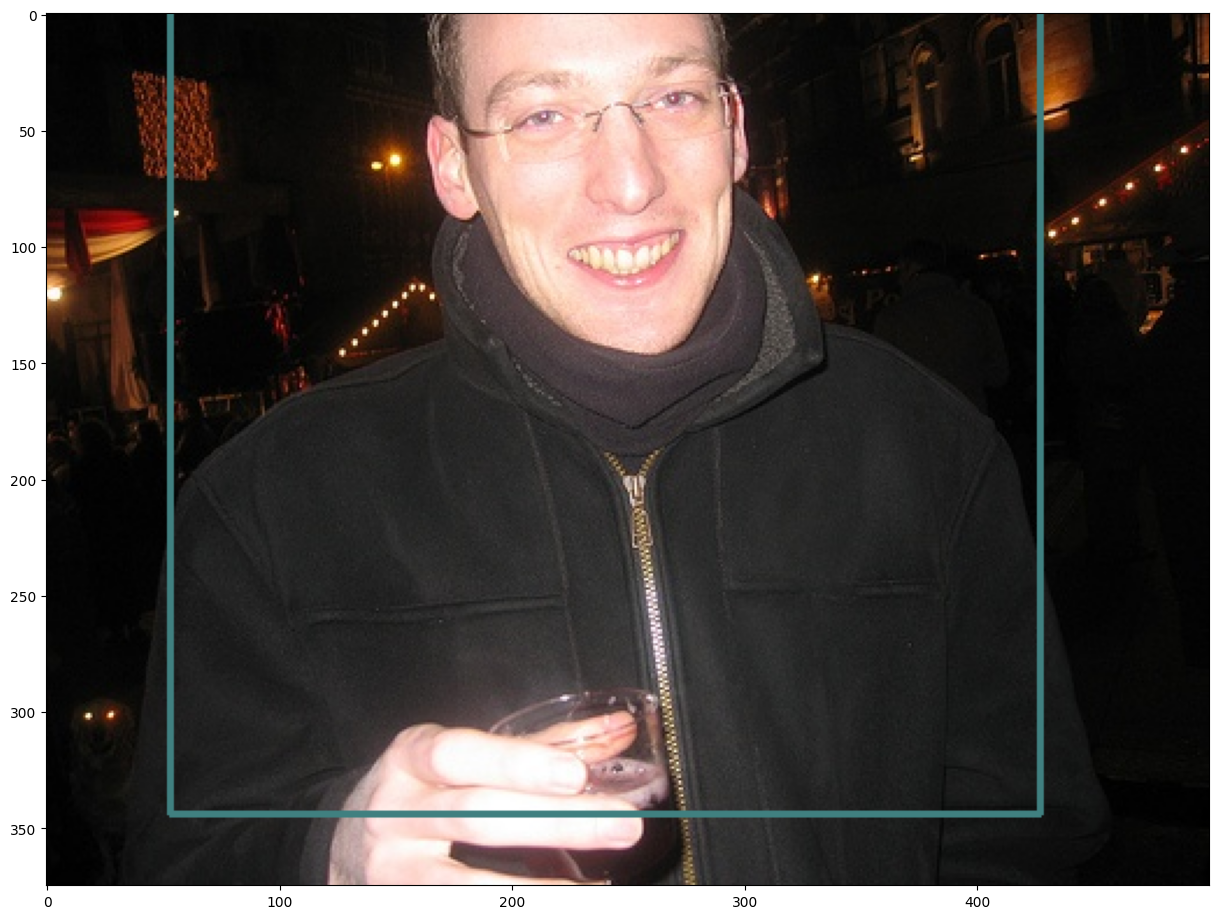

In [30]:
net.eval()

# select random image from val set
image_name = random.choice(val_dataset.fnames)
image = cv2.imread(os.path.join(file_root_val, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_val)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


# Kaggle submission (85%)

### Predict Result

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a508522480af44b0bc9e1299b6f28768)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中50%資料的正確率

In [31]:
root_test = '/content/VOCdevkit_2007/VOC2007test/JPEGImages/'
file_test = '/content/drive/MyDrive/Colab/HW5/A5/data/voc2007test.txt'

By using the test_evaluate function, you will obtain predictions for each image.

In [32]:
preds_submission = test_evaluate(net, test_dataset_file=file_test, img_root=root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:14<00:00, 36.86it/s]


The write_csv function will use preds_submission to write into a CSV file called 'result.csv'.

In [33]:
write_csv(preds_submission)

# Report (15%)
In your report, please include:

a. A brief discussion on your implementation.

b. Report the best train and validation accuracy in all of your experiments and discuss
any strategies or tricks you’ve employed.

c. Report the results for extra credits and also provide a discussion, if any.

# Extra Credit (15%)

• Pick a fun video like [**this one**](https://www.youtube.com/watch?v=xZGahvrep3o), run your detector on it (a subset of frames would be
OK), and produce a video showing your results.

• Try to replace the provided pre-trained network with a different one and train with
the YOLO loss on top to attempt to get better accuracy.

• Or any other methods that you try to improve the performance.